# Machine Learning on Drug Recommendation

## Setting Up The Environment

Importing packages

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns 
import re 
from wordcloud import WordCloud

import nltk # natural language tool kit 
nltk.download('punkt')

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk import word_tokenize
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to C:\Users\S I
[nltk_data]     Nivi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Extraction of Data

In [ ]:
test = pd.read_csv('workspaces/Secure-Pharmacist/Python_Model/Datasets/drugsComTest_raw.csv', index_col=False).drop(["date", "usefulCount"], axis=1)
train = pd.read_csv('workspaces/Secure-Pharmacist/Python_Model/Datasets/drugsComTrain_raw.csv', index_col=False).drop(["date", "usefulCount"], axis=1)

train.head()

,uniqueID,drugName,condition,review,rating
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9


## Cleaning Of Datasets

### Checking for Null Values and Replacing if any

Train Dataset

In [28]:
print('Before dropping:\n', train.isna().sum())
train = train.dropna()
print('After dropping:\n', train.isna().sum())

Before dropping:
 uniqueID     0
drugName     0
condition    0
review       0
rating       0
keywords     0
dtype: int64
After dropping:
 uniqueID     0
drugName     0
condition    0
review       0
rating       0
keywords     0
dtype: int64


Test Dataset

In [17]:
print('Before dropping:\n', test.isna().sum())
test = test.dropna()
print('After dropping:\n', test.isna().sum())

Before dropping:
 uniqueID     0
drugName     0
condition    0
review       0
rating       0
dtype: int64
After dropping:
 uniqueID     0
drugName     0
condition    0
review       0
rating       0
dtype: int64


### Cleaning the Review Column

In [21]:
def clean_text(Review):
    Review = str(Review).lower() # convert to lowercase
    Review = re.sub('\[.*?\]', '', Review)
    Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
    Review = re.sub('<.*?>+', '', Review)
    Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
    Review = re.sub('\n', '', Review)
    Review = re.sub('\w*\d\w*', '', Review)
    return Review

stop_words = set(stopwords.words('english'))
stopword = []

def remove_stopword(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

Train Dataset

In [22]:
train['review'] = train['review'].apply(clean_text)
print(train['review'])

sentence = train['review'][0]
train['keywords'] = train['review'].apply(lambda row: remove_stopword(stop_words, row))
print(train['keywords'].head())

0         it has no side effect i take it in combination...
1         my son is halfway through his fourth week of i...
2         i used to take another oral contraceptive whic...
3         this is my first time using any form of birth ...
4         suboxone has completely turned my life around ...
                                ...                        
161292    i wrote my first report in midoctober of   i h...
161293    i was given this in iv before surgey i immedia...
161294    limited improvement after  months developed ba...
161295     been on thyroid medication  years i spent my ...
161296     had chronic constipation all my adult life tr...
Name: review, Length: 160398, dtype: object
0    [side, effect, take, combination, bystolic, mg...
1    [son, halfway, fourth, week, intuniv, became, ...
2    [used, take, another, oral, contraceptive, pil...
3    [first, time, using, form, birth, control, gla...
4    [suboxone, completely, turned, life, around, f...
Name: keywords, dtype

Test Dataset

In [23]:
test['review'] = test['review'].apply(clean_text)
print(test['review'])

sentence = test['review'][0]
test['keywords'] = test['review'].apply(lambda row: remove_stopword(stop_words, row))
print(test['keywords'].head())

0         tried a few antidepressants over the years ci...
1        my son has  disease and has done very well on ...
2                              quick reduction of symptoms
3        contrave combines drugs that were used for alc...
4        i have been on this birth control for one cycl...
                               ...                        
53761    i have taken tamoxifen for  years side effects...
53762     been taking lexapro escitaploprgram since feb...
53763     married  years old and i have no kids taking ...
53764    i was prescribed nucynta for severe neckshould...
53765                                             it works
Name: review, Length: 53471, dtype: object
0    [tried, antidepressants, years, citalopram, fl...
1    [son, disease, done, well, asacol, complaints,...
2                         [quick, reduction, symptoms]
3    [contrave, combines, drugs, used, alcohol, smo...
4    [birth, control, one, cycle, reading, reviews,...
Name: keywords, dtype: object


## General Analysis Of Data

Train Dataset

In [29]:
print(train.shape)
print(train.info())

(160398, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uniqueID   160398 non-null  int64 
 1   drugName   160398 non-null  object
 2   condition  160398 non-null  object
 3   review     160398 non-null  object
 4   rating     160398 non-null  int64 
 5   keywords   160398 non-null  object
dtypes: int64(2), object(4)
memory usage: 8.6+ MB
None


Test Dataset

In [30]:
print(train.shape)
print(train.info())

(160398, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uniqueID   160398 non-null  int64 
 1   drugName   160398 non-null  object
 2   condition  160398 non-null  object
 3   review     160398 non-null  object
 4   rating     160398 non-null  int64 
 5   keywords   160398 non-null  object
dtypes: int64(2), object(4)
memory usage: 8.6+ MB
None


## Visualization For Dataset

### Top Conditions based on Drug Availability

Calculating Data

In [41]:
topConditions = train['condition'].value_counts().head(10)
print(topConditions)

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64


Creation Of Pie Chart

<BarContainer object of 10 artists>

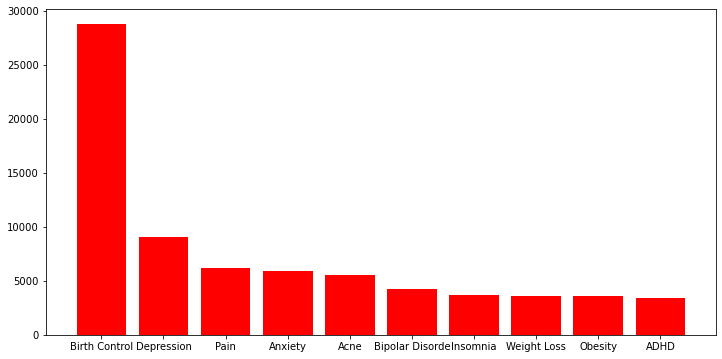

In [50]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(topConditions.index, topConditions.values, width=0.8, color='r')

From the above Graph we can see that most number of medicines is there for Birth Control, next being Depression.

### Significant Textual Data Points

Data Calculation

In [37]:
text = " ".join(str(each) for each in train['keywords'])

Creation Of Bar Chart

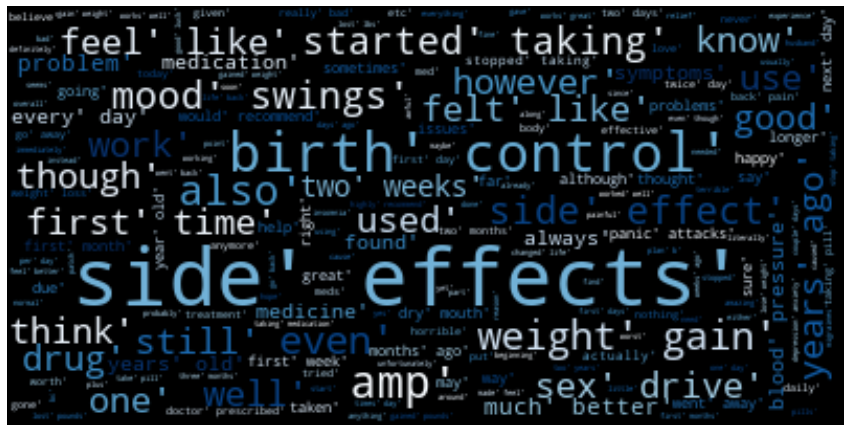

In [64]:
wordcloud = WordCloud(max_words=200,colormap='Blues', background_color="black").generate(text)
plt.figure(figsize=(15,10))

plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points have been highlighted in this word cloud.

## Machine Learning Model

Creation of Data Used For Training ML Model

In [55]:
x = train['keywords'].astype(str)
y = train['rating'].astype(str)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state = 42, test_size = 0.20)
X_train.shape,X_test.shape,Y_train.shape

((128318,), (32080,), (128318,))

Creating an object of Pipeline and Fitting Data

In [62]:
pipeline = Pipeline([('vect', CountVectorizer(stop_words= "english", lowercase = True)), 
                     ('tfidf', TfidfTransformer(use_idf = True, smooth_idf = True)),
                     ('clf', MultinomialNB(alpha =1)),])

model = pipeline.fit(X_train,Y_train)

Accuracy Testing

In [63]:
print('Training accuracy:', model.score(X_train,y_train))
print('Test accuracy:', model.score(X_test,y_test))

Training accuracy: 0.3605106064620708
Test accuracy: 0.34457605985037404
